# <u>**Streaming Service Comparison**</u>

### **Objective:**
- Determine which streaming platform hosts the majority of show titles, content, and genres I enjoy so that I can pare down the services to which I subscribe. 

### **Data Sources:**
- [Netflix via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-netflix-dataset)
- [Hulu via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-hulu-dataset)
- [Prime via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-amazon-prime-dataset/data)
- [AppleTV via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-apple-tv-dataset)
- [Streaming Service Pricing](https://github.com/rkynhoff/Streaming_Service_Comparisons/blob/main/Data/Streaming_Services_Pricing_Histories.csv)
    - Created manually using [Price_History_Reference.docx](https://github.com/rkynhoff/Streaming_Service_Comparisons/blob/main/Pricing_History_Reference.docx)

## **Data Collection & Loading**

### **Import Pandas, Numpy, Matplotlib, Wordcloud, and PIL**

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
import seaborn as sn
from wordcloud import WordCloud
from PIL import Image

### **Data Load**

In [207]:
# Load in each file separately
apple = pd.read_csv("Data/AppleTV.csv")
hulu = pd.read_csv("Data/Hulu.csv")
netflix = pd.read_csv("Data/Netflix.csv")
prime = pd.read_csv("Data/Prime.csv")
prices = pd.read_csv("Data/Streaming_Services_Pricing_Histories.csv")


### **Streaming Services Data Dictionary**
This is the data dictionary associated with the four original streaming service DataFrames, apple, hulu, netflix, and prime. Each DataFrame contains the same eight columns.				

| Field/Column  | Description | Source | Data Type | Example |
|:--------------|:------------|:-------|:----------|:--------|
| title | The name of the movie or tv show. | Original csv files  | text string | Breakfast at Tiffany's |
| type | The title content type, either "move" or "tv" | Original csv files | text string | movie |
| genres | Includes all available genres for the title. | Original csv files | text string  | Comedy, Drama, Romance |
| releaseYear | The year the movie or tv show was released according to the streaming platform. | Original csv files | int | 1961 |
| imdbId | The IMDb ID, if present, a unique value used in the URL of the IMDb content listing. | Original csv files | string | tt0054698 |
| imdbAverageRating | The average rating by customers on IMDb | Original csv files | float | 7.6 |
| imdbNumVotes | The total number of votes by customers on IMDb | Original csv files | int | 197447 |
| availableCountries | List of countries in which the title is available. | Original csv files | text string | CA, US |

### **Prices Data Dictionary**
This is the data dictionary associated with the prices DataFrames which containes three columns. 				

| Field/Column  | Description | Source | Data Type | Example |
|:--------------|:------------|:-------|:----------|:--------|
| Service_Name | The streaming platform name. | Original csv file | text string | AppleTV |
| date | The month and year to which the price corresponds. | Original csv file | string | Nov-2019 |
| price | The monthly subscription price for the associated streaming platform, month, and year. | Original csv file | float  | 4.99 |

In [208]:
# Checking the datatypes of the prices df
prices.dtypes

Service_Name     object
Date             object
Price           float64
dtype: object

### **Preliminary Data Exploration**

In [209]:
# To view a few rows of the prices DataFrame
display(prices)

,Service_Name,Date,Price
0,AppleTV,Nov-19,4.99
1,AppleTV,Dec-19,4.99
2,AppleTV,Jan-20,4.99
3,AppleTV,Feb-20,4.99
4,AppleTV,Mar-20,4.99
...,...,...,...
251,Prime,Oct-24,14.99
252,Prime,Nov-24,14.99
253,Prime,Dec-24,14.99
254,Prime,Jan-25,14.99


The prices df appears to have a date column in month/year. I will need to reformat that date field.

In [210]:
# I want to see the pricing structure of each streaming service in the df 
prices.groupby("Service_Name")["Price"].value_counts()

Service_Name  Price
AppleTV       4.99     35
              9.99     17
              6.99     12
Hulu          7.99     24
              5.99     23
              6.99     12
              9.99      5
Netflix       6.99     28
              8.99     26
              9.99     10
Prime         14.99    36
              8.99     26
              12.99     2
Name: count, dtype: int64

In [211]:
# View the head of each service dataframe without combining the dataframes together yet (this will be a future step)
# Create a variable to include a list of all dataframes recently imported
services = [apple, hulu, netflix, prime]
# Display only the head of each dataframe separately
for s in services:
    display(s.head())

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113746.0,NaN
1,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2361972.0,NaN
2,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1243981.0,NaN
3,Citizen Kane,movie,"Drama, Mystery",1941.0,tt0033467,8.3,478980.0,NaN
4,Metropolis,movie,"Drama, Sci-Fi",1927.0,tt0017136,8.3,193058.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,9061.0,NaN
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.4,7862.0,NaN
2,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2361972.0,NaN
3,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,524186.0,NaN
4,My Life Without Me,movie,"Drama, Romance",2003.0,tt0314412,7.4,26183.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,9061.0,NaN
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.4,7862.0,NaN
2,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1243981.0,NaN
3,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,524186.0,NaN
4,Kill Bill: Vol. 1,movie,"Action, Crime, Thriller",2003.0,tt0266697,8.2,1242949.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,9061.0,NaN
1,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113746.0,NaN
2,Judgment Night,movie,"Action, Crime, Drama",1993.0,tt0107286,6.6,19770.0,NaN
3,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2361972.0,NaN
4,Citizen Kane,movie,"Drama, Mystery",1941.0,tt0033467,8.3,478980.0,NaN


In [212]:
# View the combinations and counts of availableCountries field in each df
for s in services:
    display(s.value_counts("availableCountries"))

availableCountries
US                                31
CA                                11
CA, US                             7
GB                                 7
ES                                 3
AU, CA, NO, US                     2
GB, US                             2
DE                                 2
AR, BR, CL, CO, MX                 1
AT, CH, DE, FR, GB, IE, IT, US     1
AU, US                             1
AU                                 1
FR                                 1
IN                                 1
Name: count, dtype: int64

availableCountries
JP        27
US        13
JP, US     3
Name: count, dtype: int64

availableCountries
AD, AE, AG, AL, AO, AR, AT, AU, AZ, BA, BB, BE, BG, BH, BM, BO, BR, BS, BY, BZ, CA, CH, CI, CL, CM, CO, CR, CU, CV, CY, CZ, DE, DK, DO, DZ, EC, EE, EG, ES, FI, FJ, FR, GB, GF, GG, GH, GI, GQ, GR, GT, HK, HN, HR, HU, ID, IE, IL, IN, IQ, IS, IT, JM, JO, JP, KE, KR, KW, LB, LC, LI, LT, LU, LV, LY, MA, MC, MD, ME, MG, MK, ML, MT, MU, MX, MY, MZ, NE, NG, NI, NL, NO, NZ, OM, PA, PE, PF, PH, PK, PL, PS, PT, PY, QA, RO, RS, SA, SC, SE, SG, SI, SK, SM, SN, SV, TC, TH, TN, TR, TT, TW, TZ, UA, UG, US, UY, VE, YE, ZA, ZM, ZW    11
TZ                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

availableCountries
US                79
JP                45
GB, GG, IE        18
CA                14
BR                13
                  ..
IT, SM, US, VA     1
SN                 1
NE                 1
TR                 1
US, ZA             1
Name: count, Length: 94, dtype: int64

Based on output from the dataframe heads and from the availableCountries value counts, I can surmise that very few rows contain availableCountries data. I will likely drop this column in the future.

In [213]:
# Display the information for each DataFrame simulatneously

for s in services:
    display(s.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18537 entries, 0 to 18536
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               17953 non-null  object 
 1   type                18537 non-null  object 
 2   genres              17860 non-null  object 
 3   releaseYear         18506 non-null  float64
 4   imdbId              17013 non-null  object 
 5   imdbAverageRating   16597 non-null  float64
 6   imdbNumVotes        16597 non-null  float64
 7   availableCountries  71 non-null     object 
dtypes: float64(3), object(5)
memory usage: 1.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10501 entries, 0 to 10500
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               9829 non-null   object 
 1   type                10501 non-null  object 
 2   genres              10137 non-null  object 
 3   releaseYear         10460 non-null  float64
 4   imdbId              9400 non-null   object 
 5   imdbAverageRating   9087 non-null   float64
 6   imdbNumVotes        9087 non-null   float64
 7   availableCountries  43 non-null     object 
dtypes: float64(3), object(5)
memory usage: 656.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21172 entries, 0 to 21171
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               20478 non-null  object 
 1   type                21172 non-null  object 
 2   genres              20807 non-null  object 
 3   releaseYear         21133 non-null  float64
 4   imdbId              19597 non-null  object 
 5   imdbAverageRating   19411 non-null  float64
 6   imdbNumVotes        19411 non-null  float64
 7   availableCountries  162 non-null    object 
dtypes: float64(3), object(5)
memory usage: 1.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71417 entries, 0 to 71416
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               69676 non-null  object 
 1   type                71417 non-null  object 
 2   genres              69258 non-null  object 
 3   releaseYear         71222 non-null  float64
 4   imdbId              64804 non-null  object 
 5   imdbAverageRating   62419 non-null  float64
 6   imdbNumVotes        62419 non-null  float64
 7   availableCountries  319 non-null    object 
dtypes: float64(3), object(5)
memory usage: 4.4+ MB


None

In [214]:
# Get a sum of the total row count from each dataframe
total_rows = len(apple) + len(hulu) + len(netflix) + len(prime)
print(f"The total row count is {total_rows} for all dataframes.")

The total row count is 121627 for all dataframes.


### **Initial Insights**
- There are a total of 121,627 rows among all raw dataframes
- Each DataFrame contains the same column headings
- None of the DataFrames contain a column for the source of the data
- All numerical columns appear to be floats and don't need to be
    - Change ***releaseYear*** and ***imdbNumVotes*** to integers
- The majority of the titles displayed contain multiple genres in the ***genres*** column
- The ***imdbId*** columns appear to match 
    - *American Beauty* in the 1st and 3rd DataFrames
    - *Forest Gump* in the 1st, 2nd and 4th DataFrames
- Of all the rows displayed, none include ***availableCountries*** data
    - Further information proves that this data point is not prevelent throughout the four DataFrames
- The prices DataFrame appears to have a date column formated as Mon-YYYY
    - I will need to reformat that to datetime


### **Preliminary Data Manipulation**

In [215]:
# Add a column to each DataFrame to identify the data source since individually they do not have an identifier 
# This is to ensure the data is discernable after the merge when duplicate content is present because similar titles can be found with multiple service providers
apple["Service_Name"] = "AppleTV"
hulu["Service_Name"] = "Hulu"
netflix["Service_Name"] = "Netflix"
prime["Service_Name"] = "Prime"

# Using a previously made variable, created a for loop to run through each dataframe and display only the first two rows of each
# This is to ensure the column names and values were added propertly
for s in services:
    display(s.head(2))

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113746.0,NaN,AppleTV
1,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2361972.0,NaN,AppleTV


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,9061.0,NaN,Hulu
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.4,7862.0,NaN,Hulu


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,9061.0,NaN,Netflix
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.4,7862.0,NaN,Netflix


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,9061.0,NaN,Prime
1,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113746.0,NaN,Prime


### **Data Merge**

In [216]:
# Merge the streaming DataFrames together into one by appending them to the end of each other since they are all using the same column names
streaming_v1 = pd.concat([apple, hulu, netflix, prime], axis = 0)

# Based on above initial review, check to ensure there are a total of 121,627 rows in the new dataframe
streaming_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121627 entries, 0 to 71416
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   title               117936 non-null  object 
 1   type                121627 non-null  object 
 2   genres              118062 non-null  object 
 3   releaseYear         121321 non-null  float64
 4   imdbId              110814 non-null  object 
 5   imdbAverageRating   107514 non-null  float64
 6   imdbNumVotes        107514 non-null  float64
 7   availableCountries  595 non-null     object 
 8   Service_Name        121627 non-null  object 
dtypes: float64(3), object(6)
memory usage: 9.3+ MB


### **Data Cleaning & Preparation**

In [217]:
# Convert the Date column in the prices DataFrame to a date format from month-year
# The %b represents the abbreviated month and %y represents the year
prices["Date"] = pd.to_datetime(prices["Date"], format="%b-%y")
# If I stop here, I get an output of "2019-11-01" for the date, but I want MM/YYYY
# The strftime, or string format time function, puts the date in the MM/YYYY format I am looking for
prices["Date"] = prices["Date"].dt.strftime("%m/%Y")
# View the first few rows to ensure the date is formatted how I wanted it 
prices.head(3)

,Service_Name,Date,Price
0,AppleTV,11/2019,4.99
1,AppleTV,12/2019,4.99
2,AppleTV,01/2020,4.99


In [218]:
# Drop the availableCountries column given that less than 1% (0.0054%) of entries utilize this data element
streaming_v1.drop("availableCountries", axis = 1, inplace=True)

# Display only the columns to ensure the dropped column is gone
streaming_v1.columns

Index(['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating',
       'imdbNumVotes', 'Service_Name'],
      dtype='object')

In [219]:
# Rename the columns 
streaming_v1.rename(columns={"title":"Title","type":"Content_Type","genres":"Combined_Genres","releaseYear":"Release_Year","imdbId":"IMDb_ID","imdbAverageRating":"IMDb_Avg_Rating","imdbNumVotes":"IMDb_Votes_Count"},inplace = True)
streaming_v1.columns


Index(['Title', 'Content_Type', 'Combined_Genres', 'Release_Year', 'IMDb_ID',
       'IMDb_Avg_Rating', 'IMDb_Votes_Count', 'Service_Name'],
      dtype='object')

In [220]:
# Change Release_Year, IMDb_Votes_Counts from floats to integers 
streaming_v1[["Release_Year","IMDb_Votes_Count"]] = streaming_v1[["Release_Year","IMDb_Votes_Count"]].apply(np.int64)
# Change Service_Name & Combined_Genres to string
streaming_v1[["Service_Name","Combined_Genres"]] == streaming_v1[["Service_Name","Combined_Genres"]].astype(str)

# Display only the data types to ensure the data types were changed
streaming_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121627 entries, 0 to 71416
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             117936 non-null  object 
 1   Content_Type      121627 non-null  object 
 2   Combined_Genres   118062 non-null  object 
 3   Release_Year      121627 non-null  int64  
 4   IMDb_ID           110814 non-null  object 
 5   IMDb_Avg_Rating   107514 non-null  float64
 6   IMDb_Votes_Count  121627 non-null  int64  
 7   Service_Name      121627 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 8.4+ MB


c:\Users\rkynhoff\OneDrive - University of Rochester\Documents\CodeLouisville\Streaming_Service_Comparisons\venv\Lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [221]:
# Determine how many titles contain null values
print("There are",streaming_v1["Title"].isna().sum(),"rows with null values in the Title column.")

There are 3691 rows with null values in the Title column.


In [222]:
# Drop the rows containing null values in the Title column
streaming_v1 = streaming_v1.dropna(subset=["Title"])

# Ensure duplicate rows were dropped
streaming_v1.info()

# Can see in the results that the total entries went from 121,627 to 117,936; a drop of 3,691 rows


<class 'pandas.core.frame.DataFrame'>
Index: 117936 entries, 0 to 71416
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             117936 non-null  object 
 1   Content_Type      117936 non-null  object 
 2   Combined_Genres   115685 non-null  object 
 3   Release_Year      117936 non-null  int64  
 4   IMDb_ID           110814 non-null  object 
 5   IMDb_Avg_Rating   107514 non-null  float64
 6   IMDb_Votes_Count  117936 non-null  int64  
 7   Service_Name      117936 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 8.1+ MB


In [223]:
# Determine how many duplicated rows exist
print("There are", streaming_v1.duplicated().sum(),"duplicated rows.")

There are 12 duplicated rows.


In [224]:
# Taking a look at the duplicated rows since there are so few & sort by title alphabetically with the default ascending
streaming_v1[streaming_v1.duplicated(keep=False)].sort_values("Title")

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
3556,A Personal Journey with Martin Scorsese Throug...,movie,"Biography, Documentary, History",1995,tt0112120,8.5,5212,AppleTV
14194,A Personal Journey with Martin Scorsese Throug...,movie,"Biography, Documentary, History",1995,tt0112120,8.5,5212,AppleTV
45884,Belle,movie,"Fantasy, Horror",2023,tt12373754,5.4,173,Prime
36452,Belle,movie,"Fantasy, Horror",2023,tt12373754,5.4,173,Prime
43425,Burn,movie,NaN,2014,NaN,NaN,-9223372036854775808,Prime
25558,Burn,movie,NaN,2014,NaN,NaN,-9223372036854775808,Prime
51888,Flower Boy,movie,NaN,2021,NaN,NaN,-9223372036854775808,Prime
51088,Flower Boy,movie,NaN,2021,NaN,NaN,-9223372036854775808,Prime
15991,Kevin Hart: The Kennedy Center Mark Twain Priz...,movie,Comedy,2024,tt31805297,6.6,795,Netflix
15938,Kevin Hart: The Kennedy Center Mark Twain Priz...,movie,Comedy,2024,tt31805297,6.6,795,Netflix


In [225]:
# Since the rows do appear to be fully dupliated, I will drop the duplicate rows here
streaming_v2 = streaming_v1.drop_duplicates()

# Reset the index
streaming_v2 = streaming_v2.reset_index(drop=True)

# View total of entires, which should equal 117,924 (117,936  - 12)
streaming_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117924 entries, 0 to 117923
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             117924 non-null  object 
 1   Content_Type      117924 non-null  object 
 2   Combined_Genres   115675 non-null  object 
 3   Release_Year      117924 non-null  int64  
 4   IMDb_ID           110805 non-null  object 
 5   IMDb_Avg_Rating   107505 non-null  float64
 6   IMDb_Votes_Count  117924 non-null  int64  
 7   Service_Name      117924 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 7.2+ MB


In [226]:
# Determine how man rows include null values for Combined_Genres
print("There are",streaming_v1["Combined_Genres"].isna().sum(),"rows with null values in the Combined_Genres column.")

There are 2251 rows with null values in the Combined_Genres column.


In [227]:
# View the rows with null values for Combined_Genres
# May need to address this later
streaming_v1.loc[streaming_v1["Combined_Genres"].isnull()]

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
2016,Anthappuram,movie,NaN,1980,tt0315778,5.6,7,AppleTV
3062,Siste trikk,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV
3134,Breathe without Water,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV
3140,El Arte De La Guerra,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV
3569,Atze Schröder - Revolution,movie,NaN,2010,NaN,NaN,-9223372036854775808,AppleTV
...,...,...,...,...,...,...,...,...
69129,Shea-suru ra! Instanto râmen arenji bu hajimem...,tv,NaN,2022,tt19408810,NaN,-9223372036854775808,Prime
69720,Secrets of the Exhibit,tv,NaN,2015,tt14546892,NaN,-9223372036854775808,Prime
69996,Hee!Hee!Hoo!,tv,NaN,2023,tt27010738,NaN,-9223372036854775808,Prime
70603,Kusuburi onna to sundome onna,tv,NaN,2023,tt29471798,NaN,-9223372036854775808,Prime


In [228]:
# Now that duplicated rows are gone, I want to see if there might be duplicated content baesd on IMDb_ID, Release_Year, Title, Content_Type, and Service Name
streaming_v2[streaming_v2.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
38758,Amr's in Trouble,movie,"Romance, Comedy",2019,NaN,NaN,-9223372036854775808,Netflix
42247,Amr's in Trouble,movie,NaN,2019,NaN,NaN,-9223372036854775808,Netflix
94240,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime
93318,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime
13540,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV
13765,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV
42873,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix
43190,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix
106324,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime
107543,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime


In [229]:
# Based on the output above, I can see there is duplicated content and rows where genres could be combined into one row for each Service_Name

# Remove the duplicated rows that have a null value in the Combined_Genres column by index number
streaming_v3 = streaming_v2.drop([108778,103300,41424,109487,109547,90404,38244,12388,42247])
# Reset index
streaming_v3 = streaming_v3.reset_index(drop=True)
# Double check
streaming_v3[streaming_v3["Title"] == "The Final Ride"]


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
88619,The Final Ride,movie,"Comedy, Horror",2019,tt9869668,5.3,84,Prime
105102,The Final Ride,movie,"Crime, Action",2021,NaN,NaN,-9223372036854775808,Prime


In [230]:
# Redisplay the duplicated content baesd on IMDb_ID, Release_Year, Title, Content_Type, and Service Name

grouped_dupes = streaming_v3[streaming_v3.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])
grouped_dupes

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
94235,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime
93313,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime
13539,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV
13764,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV
42869,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix
43186,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix
106318,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime
107537,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime
107658,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Prime
105247,Fences,movie,Documentary,2023,NaN,NaN,-9223372036854775808,Prime


In [231]:
# See AI_Notes.docx for more information on how this code block came about
# Initialize an empty dictionary in which to store concatenated genres
concatenated_genres = {}

# Iterate over each row in the grouped_dupes dataframe
for index, row in grouped_dupes.iterrows():
    # Createa a unique key for each row in the grouped_dupes dataframe by combining certain columns
    key = (row["Title"], row["Content_Type"],row["Release_Year"], row["IMDb_ID"], row["IMDb_Votes_Count"], row["Service_Name"])
    # Checks if the key exists in the concatenated_genres dictionary & if so, append the new genres from the currnt row to the existing list of genres in the dictionary with a comma and space after each
    if key in concatenated_genres:
        # Check if the existing value is a string
        if isinstance(concatenated_genres[key], str):
            # If it's a string, convert the new value to a string and append
            concatenated_genres[key] += ', ' + str(row["Combined_Genres"])
    # If the key doesn't exist in the dictionary, create a new entry in the dictionary with the combined genres from the current row, with a comma and a space
        else:
            concatenated_genres[key] = str(concatenated_genres[key]) + ', ' + str(row["Combined_Genres"])
    else:
        concatenated_genres[key] = str(row["Combined_Genres"]) + ', '

# Iniitialize a list to 
result_data = []
# Iterate over each key-value pair in the concatenated_genres dictionary
for key, genres in concatenated_genres.items():
    # Append a new list to the result_data list which contains the key values and the genres with the trailing comma and space removed
    result_data.append([key[0], key[1], genres[:-2], key[2], key[3], key[4], key[5]])

# Create a new dataframe from the result_data list with specified column names
result_df = pd.DataFrame(result_data, columns = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","IMDb_Votes_Count","Service_Name"])
# Create a new column in the new dataframe and assign the value of "none"
# This was done because each time I attempted to add the IMDb_Avg_Rating column to the key list above, the code would fail because it is an integer column in the original dataframe
result_df["IMDb_Avg_Rating"] = "None"
# Define a list of columns in the order in which I want them in the new dataframe
column_titles = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","IMDb_Avg_Rating","IMDb_Votes_Count","Service_Name"]
# reorder the columns in the new dataframe to match the specified order in the above code line
result_df = result_df.reindex(columns=column_titles)
# Display the new dataframe
display(result_df)

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
0,Aurora,movie,"Animation, , Horr",2019,NaN,None,-9223372036854775808,Prime
1,De olhos abertos,movie,"Animation, , Drama, W",2023,NaN,None,-9223372036854775808,AppleTV
2,De olhos abertos,movie,"Animation, , Drama, W",2023,NaN,None,-9223372036854775808,Netflix
3,De olhos abertos,movie,"Animation, , Drama, W",2023,NaN,None,-9223372036854775808,Prime
4,Fences,movie,"Comedy, Drama, , Documenta",2023,NaN,None,-9223372036854775808,Prime
5,Imago,movie,"Drama, Thriller, , Horr",2024,NaN,None,-9223372036854775808,Prime
6,Leonardo: The Man Who Saved Science,movie,"Documentary, History, , Documentary, History, ...",2017,NaN,None,-9223372036854775808,Prime
7,Stealing Chaplin,movie,"Comedy, , Drama, Comedy, Histo",2024,NaN,None,-9223372036854775808,Prime
8,When life gives you lemons,movie,"Animation, , Mus",2024,NaN,None,-9223372036854775808,Prime


In [232]:
# Append the newly created dataframe to the previous dataframe
streaming_v4 = pd.concat([streaming_v3,result_df], axis = 0)

# Reset the indeces
streaming_v4.reset_index(drop=True) 

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
0,Four Rooms,movie,Comedy,1995,tt0113101,6.7,113746,AppleTV
1,Forrest Gump,movie,"Drama, Romance",1994,tt0109830,8.8,2361972,AppleTV
2,American Beauty,movie,Drama,1999,tt0169547,8.3,1243981,AppleTV
3,Citizen Kane,movie,"Drama, Mystery",1941,tt0033467,8.3,478980,AppleTV
4,Metropolis,movie,"Drama, Sci-Fi",1927,tt0017136,8.3,193058,AppleTV
...,...,...,...,...,...,...,...,...
117919,Fences,movie,"Comedy, Drama, , Documenta",2023,NaN,None,-9223372036854775808,Prime
117920,Imago,movie,"Drama, Thriller, , Horr",2024,NaN,None,-9223372036854775808,Prime
117921,Leonardo: The Man Who Saved Science,movie,"Documentary, History, , Documentary, History, ...",2017,NaN,None,-9223372036854775808,Prime
117922,Stealing Chaplin,movie,"Comedy, , Drama, Comedy, Histo",2024,NaN,None,-9223372036854775808,Prime


In [233]:
# Check to ensure that one of the titles with a duplicate row matching title, content_type, release_year, and service_name, but with a null value is Genres is present with the correct combined genres
streaming_v4[streaming_v4["Title"] == "The Final Ride"]

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
88619,The Final Ride,movie,"Comedy, Horror",2019,tt9869668,5.3,84,Prime
105102,The Final Ride,movie,"Crime, Action",2021,NaN,NaN,-9223372036854775808,Prime


In [234]:
# Now I need to get the index of the rows without concatenated Combined_Genres
display(streaming_v4[streaming_v4["Title"].isin(["Aurora", "De olhos abertos", "Fences", "Imago", "Leonardo: The Man Who Saved Science", "Stealing Chaplin", "When life gives you lemons"])].sort_values(by = "Title"))

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
91225,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,Prime
10485,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,AppleTV
94235,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime
93313,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime
0,Aurora,movie,"Animation, , Horr",2019,NaN,None,-9223372036854775808,Prime
36953,Aurora,movie,"Horror, Thriller",2018,tt8821182,4.4,730,Netflix
88055,Aurora,movie,"Comedy, Drama, Romance",2019,tt8553606,6.7,1907,Prime
106318,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime
107537,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime
2,De olhos abertos,movie,"Animation, , Drama, W",2023,NaN,None,-9223372036854775808,Netflix


In [235]:
# Create new dataframe after dropping rows with specific rows
streaming_v5 = streaming_v4.drop([94235, 93313, 106318, 107536, 43186, 42869, 13764, 13539, 105247, 107657, 106975, 109439, 97904, 94725, 108565, 108553, 57863, 108963])

In [236]:
# Checking for the subset duplicates again
streaming_v5[streaming_v5.duplicated(subset = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","Service_Name"], keep = False)].sort_values(by=["Title","Combined_Genres","Service_Name"], ascending=[True,True,True]).sort_index()

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name


In [237]:
# Checking a specific title to ensure correct rows were dropped
display(streaming_v5[streaming_v5["Title"] == "Aurora"])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
10485,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,AppleTV
36953,Aurora,movie,"Horror, Thriller",2018,tt8821182,4.4,730,Netflix
88055,Aurora,movie,"Comedy, Drama, Romance",2019,tt8553606,6.7,1907,Prime
91225,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,Prime
0,Aurora,movie,"Animation, , Horr",2019,NaN,None,-9223372036854775808,Prime


In [238]:
# Check new df data types
streaming_v5.dtypes

Title               object
Content_Type        object
Combined_Genres     object
Release_Year         int64
IMDb_ID             object
IMDb_Avg_Rating     object
IMDb_Votes_Count     int64
Service_Name        object
dtype: object

In [239]:
# I see that my alterations to the rows above has changed my data type value, so I need to remove the "None" values from the IMDb_Avg_Rating column
streaming_v5["IMDb_Avg_Rating"] = streaming_v5["IMDb_Avg_Rating"].replace("None",pd.NA)
# streaming_v5.value_counts("IMDb_Avg_Rating")
streaming_v5.dtypes


Title               object
Content_Type        object
Combined_Genres     object
Release_Year         int64
IMDb_ID             object
IMDb_Avg_Rating     object
IMDb_Votes_Count     int64
Service_Name        object
dtype: object

In [240]:
# Still seeing the duplicated word "Comedy" in the COmbined_Genres column
display(streaming_v5[streaming_v5["Title"] == "Breakfast at Tiffany's"])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
50,Breakfast at Tiffany's,movie,"Comedy, Drama, Romance",1961,tt0054698,7.6,197841,AppleTV
17982,Breakfast at Tiffany's,movie,"Comedy, Drama, Romance",1961,tt0054698,7.6,197841,Hulu
48325,Breakfast at Tiffany's,movie,"Comedy, Drama, Romance",1961,tt0054698,7.6,197841,Prime


In [241]:
streaming_v5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117906 entries, 0 to 8
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Title             117906 non-null  object
 1   Content_Type      117906 non-null  object
 2   Combined_Genres   115666 non-null  object
 3   Release_Year      117906 non-null  int64 
 4   IMDb_ID           110800 non-null  object
 5   IMDb_Avg_Rating   107502 non-null  object
 6   IMDb_Votes_Count  117906 non-null  int64 
 7   Service_Name      117906 non-null  object
dtypes: int64(2), object(6)
memory usage: 8.1+ MB


In [242]:
#Obtain max number of elements in the Genres column
streaming_v4["Combined_Genres"].str.split(", ",expand=True)


,0,1,2,3,4,5,6
0,Comedy,None,None,None,None,None,None
1,Drama,Romance,None,None,None,None,None
2,Drama,None,None,None,None,None,None
3,Drama,Mystery,None,None,None,None,None
4,Drama,Sci-Fi,None,None,None,None,None
...,...,...,...,...,...,...,...
4,Comedy,Drama,,Documenta,None,None,None
5,Drama,Thriller,,Horr,None,None,None
6,Documentary,History,,Documentary,History,TV Mov,None
7,Comedy,,Drama,Comedy,Histo,None,None


In [243]:
# Split the elements in the Genres column while creating new columns for the max number 
streaming_v5[["Genre_1","Genre_2","Genre_3","Genre_4","Genre_5","Genre_6","Genre_7"]] = streaming_v5["Combined_Genres"].str.split(',',expand=True)

streaming_v5.head(2)

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7
0,Four Rooms,movie,Comedy,1995,tt0113101,6.7,113746,AppleTV,Comedy,None,None,None,None,None,None
1,Forrest Gump,movie,"Drama, Romance",1994,tt0109830,8.8,2361972,AppleTV,Drama,Romance,None,None,None,None,None


In [244]:
# Creating clean dataframe
streaming_clean = streaming_v5

In [245]:
# Create a final CSV file from the cleaned dataframe to use in Tableau
# Note this is commented out after the first run to create the file so the program doesn't fail

# streaming_clean.to_csv("Streaming_Clean_Final.csv", sep=",", index=False, header=True)

### **Begin Analysis**

### **Data Dictionary**
This is the data dictionary associated with final dataframe, streaming_clean.					

| Field | Description | Source |  Data Type | Example |
|:------|:------------|:-------|:---------- |:--------|
| Title | The name of the movie or tv show. | From the original csv files| text string | Breakfast at Tiffany's |
| Content_Type | The title content, either "movie" or "tv." | Renamed from the original service platform dataframes. | text string | movie |
| Combined_Genres | Includes all available genres in alphabetical order. | Renamed from the original service platform dataframes. | text string | Comedy, Drama, Romance |
| Release_Year | The year the movie or tv show was released according to the streaming platform.  | Renamed from the original service platform dataframes. | int | 1961 |
| IMDb_ID | The IMDb ID, if present, a unique value used in the URL of the IMDb content listing. | Renamed from the original service platform dataframes. | text string | tt0054698 |
| IMDb_Avg_Rating | The average rating by customers on IMDb  | Renamed from the original service platform dataframes. | float | 7.6|
| IMDb_Votes_Count | The total number of votes by customers on IMDb | Renamed from the original service platform dataframes. | int | 197447 |
| Service_Name | The streaming platform name. | Created field based on the service from which the data came. | text string | AppleTV |
| Genre_1 | The first genre in the Combined_Genres field, if present. | Created field from splitting the genres field from the original file into individual columns. | text string | Comedy |
| Genre_2 | The second genre in the Combined_Genres field, if present. | Created field from splitting the genres field from the original file into individual columns. | text string | Drama |
| Genre_3 | The third genre in the Combined_Genres field, if present. | Created field from splitting the genres field from the original file into individual columns. | text string | Romance |
| Genre_4 | The fourth genre in the Combined_Genres field, if present. | Created field from splitting the genres field from the original file into individual columns. | text string | NaN | 
| Genre_5 | The fifth genre in the Combined_Genres field, if present. | Created field from splitting the genres field from the original file into individual columns. | text string | NaN |
| Genre_6 | The sixth genre in the Combined_Genres field, if present. | Created field from splitting the genres field from the original file into individual columns. | text string | NaN |
| Genre_7 | The seventh genre in the Combined_Genres field, if present. | Created field from splitting the genres field from the original file into individual columns. | text string | NaN | 

In [246]:
# Checking datatypes of the new dataframe
streaming_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117906 entries, 0 to 8
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Title             117906 non-null  object
 1   Content_Type      117906 non-null  object
 2   Combined_Genres   115666 non-null  object
 3   Release_Year      117906 non-null  int64 
 4   IMDb_ID           110800 non-null  object
 5   IMDb_Avg_Rating   107502 non-null  object
 6   IMDb_Votes_Count  117906 non-null  int64 
 7   Service_Name      117906 non-null  object
 8   Genre_1           115666 non-null  object
 9   Genre_2           77185 non-null   object
 10  Genre_3           45112 non-null   object
 11  Genre_4           133 non-null     object
 12  Genre_5           32 non-null      object
 13  Genre_6           5 non-null       object
 14  Genre_7           1 non-null       object
dtypes: int64(2), object(13)
memory usage: 14.4+ MB


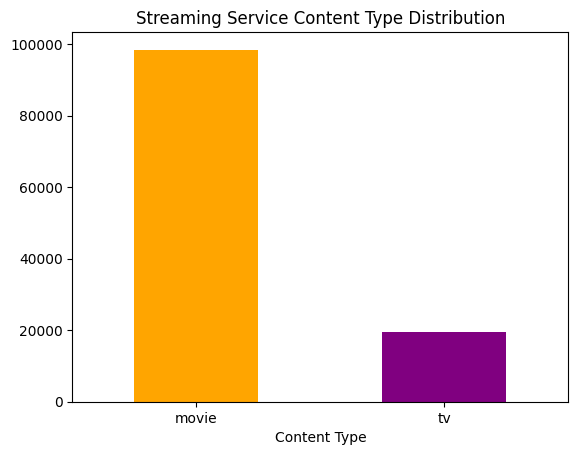

In [247]:
# Crate a bar graph to show distribution of content types from the Content_Type column
# Plot it with orange for "movies" and purple for "tv"
streaming_clean["Content_Type"].value_counts().plot(kind='bar',color=["orange","purple"])
# Add a plot title
plt.title("Streaming Service Content Type Distribution")
# Change the orientation of the x ticks
plt.xticks(rotation = 360)
# Relable the X axis
plt.xlabel("Content Type")
# Show the bar graph 
plt.show()


Content Type Analysis
- Among the four streaming services analyzed, the majority of content is steeped in movies over tv shows
- There appears to be nearly 5 times the amount of movies vs tv shows offered among all four platforms

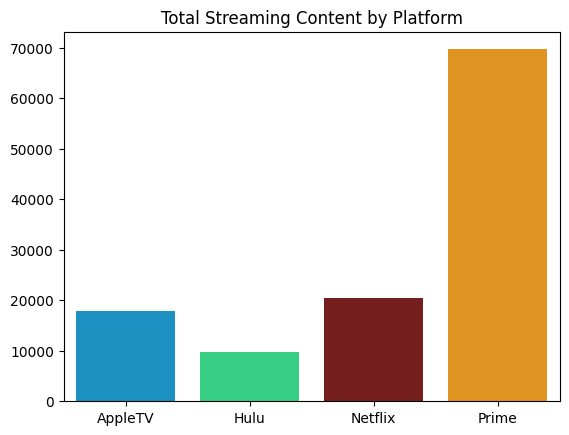

In [248]:
# Plotting which streaming platform contains the most content
chart = sn.countplot(streaming_clean, x = "Service_Name", hue = "Service_Name", palette = ["#009DDC","#1CE783","#831010","#FF9900"])
chart.set_ylabel("")
chart.set_xlabel("")
chart.set_title("Total Streaming Content by Platform")
plt.show()


Text(0.5, 0, 'Service Name')

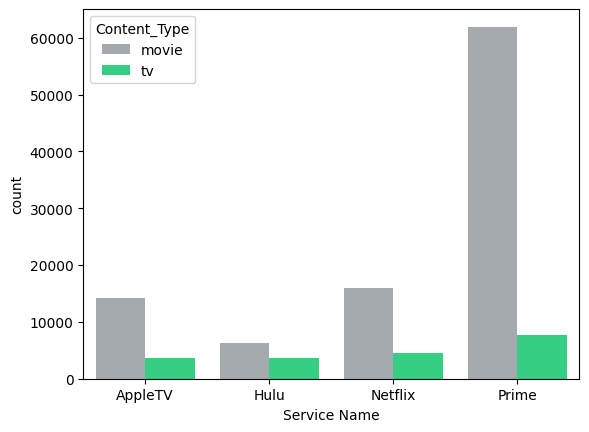

In [249]:
# Hex Codes for streaming services
# Apple: gray = #A3AAAE, blue = #009DDC
# Hulu: greeen = #1CE783, black = #001908
# Netflix: crimson = #D81F26, black = #221F1F
# Prime: orange = #FF9900, blue = #05A0D1, dark blue: #232F3E

# Counts of the content type by streaming sesrvice

sn.countplot(streaming_clean, x = "Service_Name", hue = "Content_Type", palette = ["#A3AAAE", "#1CE783"])
plt.xlabel("Service Name")



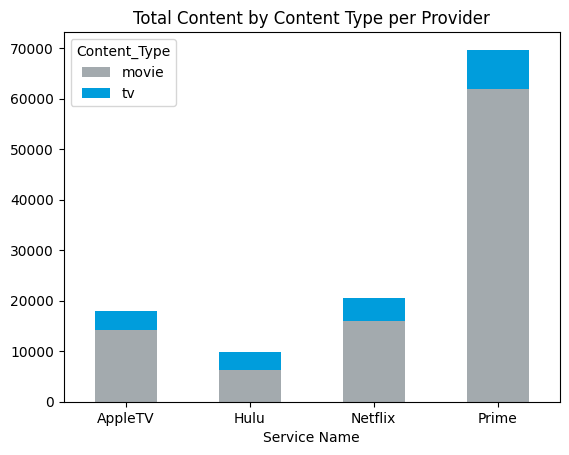

In [250]:
# Let's compare apples to apples and stack the content types to compare total content among the four service providers

# Group by Service_Name and count the number of each Content_Type
cont_type = streaming_clean.groupby("Service_Name")["Content_Type"].value_counts().unstack(fill_value = 0)

# Plot the result of the grouped data above as a stacked bar plot with specific coloring
cont_type.plot(kind =  "bar", stacked = True, color = ["#A3AAAE", "#009DDC"])
# Relable the x axis
plt.xlabel("Service Name")
# Reposition the x labels so they are horizontal with the x axis
plt.xticks(rotation = 360)
# Create a graph title
plt.title("Total Content by Content Type per Provider")
plt.show()

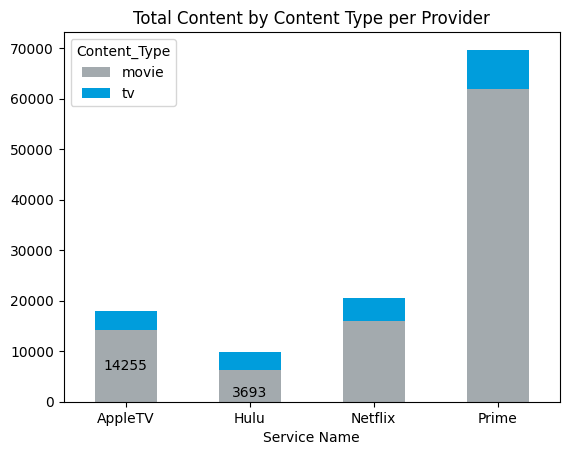

In [251]:
# Attempt at adding value_count labels 
# Group by Service_Name and count the number of each Content_Type
cont_type = streaming_clean.groupby(["Service_Name", "Content_Type"]).size().reset_index(name="count")

# Plot the result of the grouped data above as a stacked bar plot with specific coloring
cont_typepivot = cont_type.pivot_table(index="Service_Name", columns="Content_Type", values="count", fill_value=0)
cont_typepivot.plot(kind =  "bar", stacked = True, color = ["#A3AAAE", "#009DDC"])

# Relable the x axis
plt.xlabel("Service Name")
# Reposition the x labels so they are horizontal with the x axis
plt.xticks(rotation = 360)
# Create a chart title
plt.title("Total Content by Content Type per Provider")

# Get the height of the bars
bar_heights = cont_typepivot.iloc[0].values

# Get the x positions of the bars
bar_positions = range(len(cont_typepivot.columns))

# Create value count labels inside the bars on the graph
for i, height in enumerate(bar_heights):
    if height > 0:
        plt.text(bar_positions[i], height/2, str(int(height)), ha='center', va='center')

# Show the plot
plt.show()

### Content Type Analysis
- At first glance, the Prime content catalog appears to be nearly three to four times that of other providers
    - This is because much of the content within Prime is either available for rent or through a secondary subscription service
    - Additionally, Amazon Prime acquired MGM Studios in 2002, while MGM was founded in 1924, so theoretically, Prime owns the entire library of MGM content whith they likely will  not license to other streaming platforms for use
- AppleTV and Prime have similar business models in that both include movies and tv shows which are free with their monthly subscriptions, but also offer content availale for rent or purchase
    - Upon further research outside of the dataset, some MGM content is also available for rent or purchase through AppleTV 

In [252]:
# Determine the total null values in the Combined_Genres column & print the data using an f string
combined_null = streaming_clean["Combined_Genres"].isnull().sum()

print(f"There are {combined_null} null values in the Combined_Genres column.")

There are 2240 null values in the Combined_Genres column.


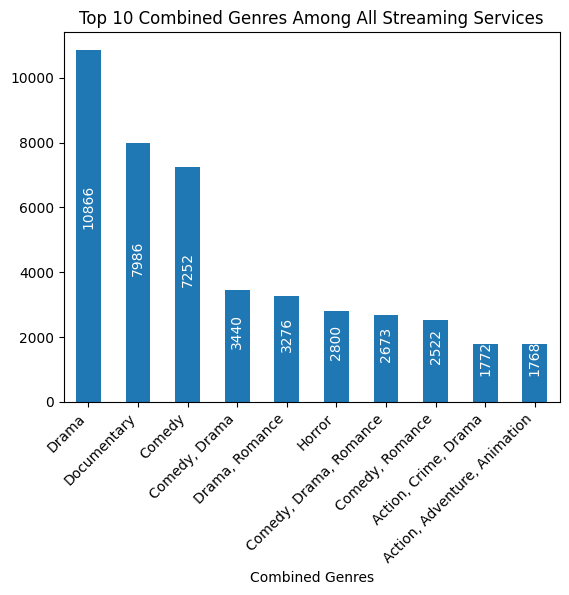

In [253]:
# Create a value count variable for the top 10 value cgenres in the Combined_Genres column and count them
genre_counts = streaming_clean["Combined_Genres"].value_counts().head(10)
# Plot the genres
genre_counts.plot.bar()

# Creating a loop to put the value count of each genre count into the middle of its respective bar vertically in white font
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width()/2, height/2, str(height), ha = "center", color = "white", rotation = 90)

# create a Combined Genres label on the x axis
plt.xlabel("Combined Genres")
# rotate x-labels to 45 degree angle with a right text orientation
plt.xticks(rotation = 45, ha = "right")
# create a graph title
plt.title("Top 10 Combined Genres Among All Streaming Services")
# Show the plot
plt.show()

Cobmined Genres Analysis
- Of the values in the Combined_Genres column, 2,204 are null. 
- The tope three values within the Combined_Genres column are actually individual genres comprising of # of the overall content among all service providers
- Within the top 5 genres, Drama was paired with Comedy # times and with Romance # times
- While horror is 6th in the list, it is also an individual genre 

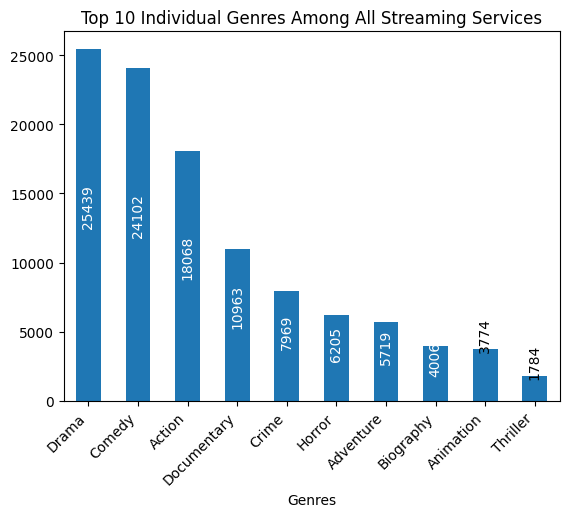

In [254]:
# Looking for the top 10 genres offered among the streaming services based on the first genre listed in the Combined_Genres column parsed into the Genre_1 column
# Create a value count variable for the top 10 value cgenres in the Combined_Genres column and count them
genre_counts = streaming_clean["Genre_1"].value_counts().head(10)
# Plot the genres
genre_counts.plot.bar()

# Creating a loop to put the value count of each genre count into the middle of its respective bar vertically in white font
for i, p in enumerate(plt.gca().patches):
    height = p.get_height()
    # For all bars but last two, show the label inside the bar with white font
    if height < 10: 
        plt.gca().text(p.get_x() + p.get_width()/2, height + 10, str(height), ha = "center", color = "black")
    elif i < len(plt.gca().patches) - 2:
        plt.gca().text(p.get_x() + p.get_width()/2, height/2, str(height), ha = "center", color = "white", rotation = 90)
    else: 
        # For the last two columns, put label above the bar in black font
        plt.gca().text(p.get_x() + p.get_width()/2, height + 10, str(height), ha = "center", color = "black", rotation = 90)

# create a Combined Genres label on the x axis
plt.xlabel("Genres")
# rotate x-labels to 45 degree angle with a right text orientation
plt.xticks(rotation = 45, ha = "right")
# create a graph title
plt.title("Top 10 Individual Genres Among All Streaming Services")
# Show the plot
plt.show()


The top 10 individual genres among all four streaming platforms are 
1. Drama
2. Comedy
3. Action
4. Documentary
5. Crime
6. Horor
7. Adventure
8. Biography
9. Animation
10. Thriller

Not surprisingly, Drama and Comedy make up the top two individual genre categories. Note that the Romance category hasn't made the top 10 of individual genres. 

<function matplotlib.pyplot.show(close=None, block=None)>

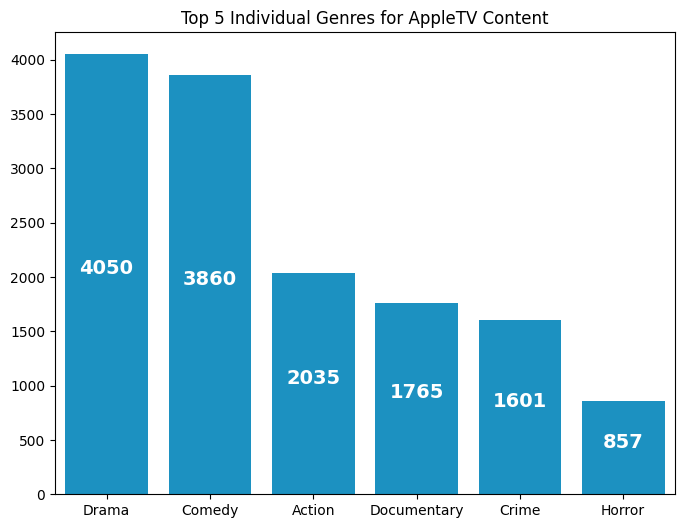

In [ ]:
# Separate the AppleTV rows from the rest of the DataFrame
apple_tv = streaming_clean[streaming_clean["Service_Name"] == "AppleTV"] 
# Group the Genre_1 column and get the total counts for each genre
apple_tv_genres = apple_tv.groupby("Genre_1")["Genre_1"].count().reset_index(name = "Count")
# Ascertain the top 5 individual genres
top_apple_tv_genres = apple_tv_genres.sort_values("Count", ascending = False).head(6)
# Set figure size 
plt.figure(figsize = (8, 6))
# Create a bar plot with specific color
sn.barplot(x = top_apple_tv_genres["Genre_1"], y = top_apple_tv_genres["Count"], color = "#009DDC")
# Plot the value counts of each genre inside the bar centered vertically in white font
# i = the index of each element in the series as an integer that starts at 0 and increments by 1 for each iteration 
# v = the value of each element in the series as the actual count & is a numeric value
# str(v) = converts the value of v to a string to be used in the bar plot
for i, v in enumerate(top_apple_tv_genres["Count"]):
    plt.text(i, v/2, str(v), color = "white", ha = "center", fontsize = 14, fontweight = 600)
# Remove x and y labels
plt.xlabel(None)
plt.ylabel(None)
# Set title
plt.title("Top 5 Individual Genres for AppleTV Content")
# Display plot
plt.show


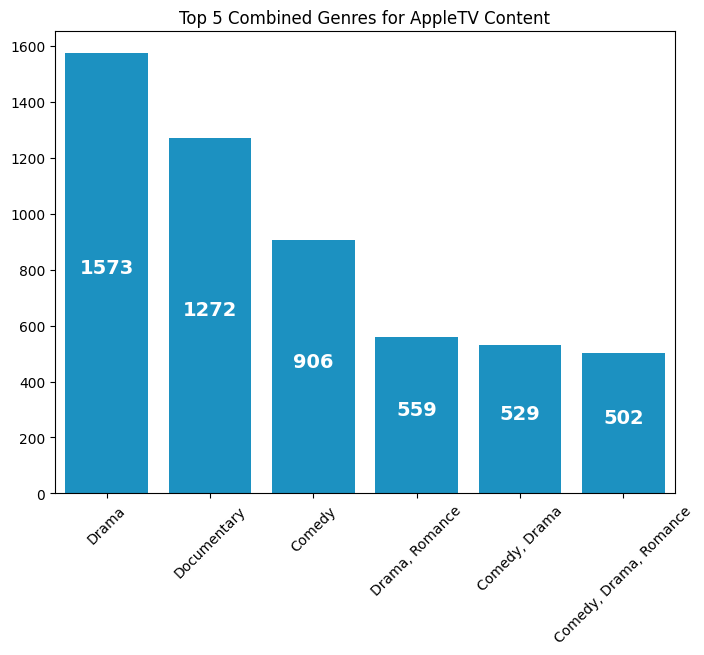

In [ ]:
# Group the Genre_1 column and get the total counts for each genre
apple_tv_genres = apple_tv.groupby("Combined_Genres")["Combined_Genres"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_apple_tv_genres = apple_tv_genres.sort_values("Count", ascending = False).head(6)
# Set figure size 
plt.figure(figsize = (8, 6))
# Create a bar plot with specific color
sn.barplot(x = top_apple_tv_genres["Combined_Genres"], y = top_apple_tv_genres["Count"], color = "#009DDC")
# Plot the value counts of each genre inside the bar centered vertically in white font
# i = the index of each element in the series as an integer that starts at 0 and increments by 1 for each iteration 
# v = the value of each element in the series as the actual count & is a numeric value
# str(v) = converts the value of v to a string to be used in the bar plot
for i, v in enumerate(top_apple_tv_genres["Count"]):
    plt.text(i, v/2, str(v), color = "white", ha = "center", fontsize = 14, fontweight = 600)
# Remove x and y labels
plt.xlabel(None)
plt.ylabel(None)
# Rotate xtick labels
plt.xticks(rotation = 45)
# Set title
plt.title("Top 5 Combined Genres for AppleTV Content")
# Display plot 
plt.show()

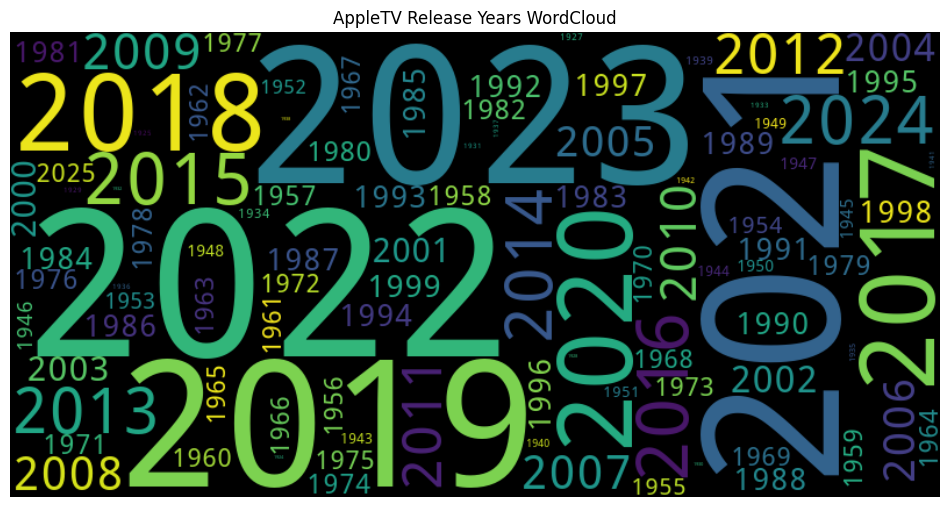

In [ ]:
# Create variable with value counts of each release year
release_yr_cnts = apple_tv["Release_Year"].value_counts()

# Convert the index of the Release Years from integers to strings because WordCloud requires strings inputs
release_yr_cnts.index = release_yr_cnts.index.map(str)

# Create the WordCloud specifying 
apple_tv_wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate_from_frequencies(release_yr_cnts)

# Setting figure size in inches
plt.figure(figsize = (12, 8))
# Show the created WordCloud with a bilinear interpolation, which is used to estimate the value of pixels used to generate the image
plt.imshow(apple_tv_wordcloud, interpolation = "bilinear")
# Do not display axes
plt.axis("off")
# Create a title for the WordCloud
plt.title("AppleTV Release Years WordCloud")
# Display plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

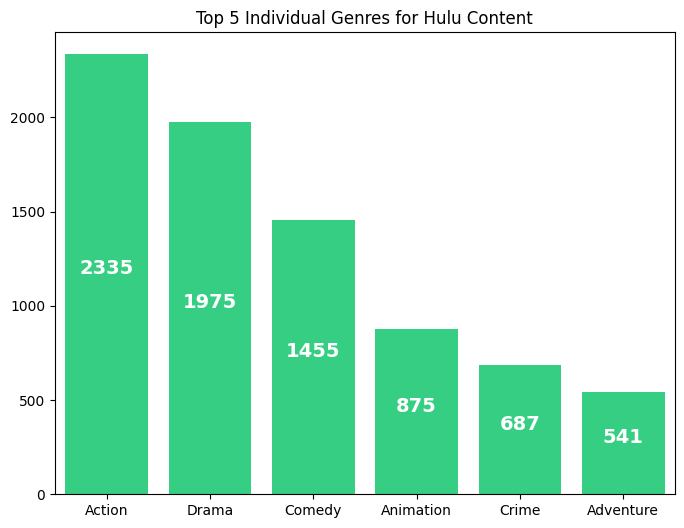

In [ ]:
# Separate the Hulu rows from the rest of the df
hulu_tv = streaming_clean[streaming_clean["Service_Name"] == "Hulu"] 
# Group the Genre_1 column and get the total counts for each genre
hulu_tv_genres = hulu_tv.groupby("Genre_1")["Genre_1"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_hulu_tv_genres = hulu_tv_genres.sort_values("Count", ascending = False).head(6)
# Set figure size 
plt.figure(figsize = (8, 6))
# Create a bar plot with specific color
sn.barplot(x = top_hulu_tv_genres["Genre_1"], y = top_hulu_tv_genres["Count"], color = "#1CE783")
# Plot the value counts of each genre inside the bar centered vertically in white font
# i = the index of each element in the series as an integer that starts at 0 and increments by 1 for each iteration 
# v = the value of each element in the series as the actual count & is a numeric value
# str(v) = converts the value of v to a string to be used in the bar plot
for i, v in enumerate(top_hulu_tv_genres["Count"]):
    plt.text(i, v/2, str(v), color = "white", ha = "center", fontsize = 14, fontweight = 600)
# Remove x and y labels
plt.xlabel(None)
plt.ylabel(None)
# Set title
plt.title("Top 5 Individual Genres for Hulu Content")
# Display plot
plt.show


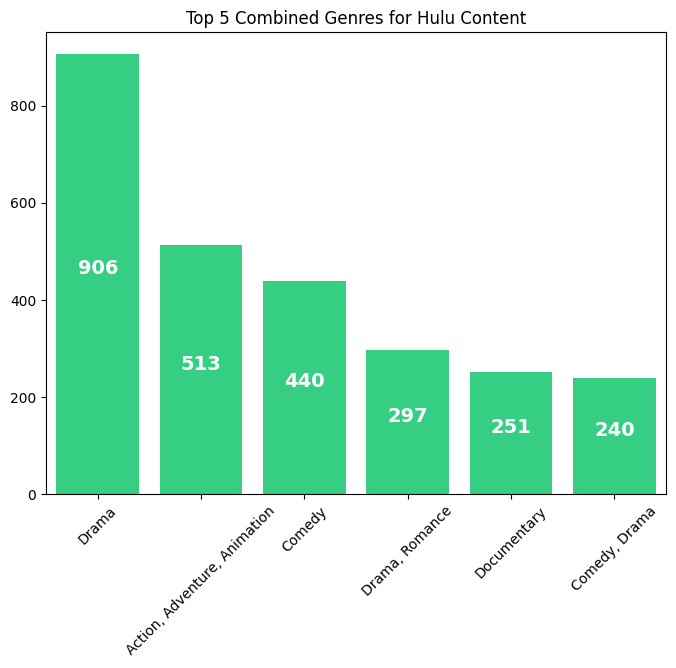

In [ ]:
# Group the Genre_1 column and get the total counts for each genre
hulu_tv_genres = hulu_tv.groupby("Combined_Genres")["Combined_Genres"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_hulu_tv_genres = hulu_tv_genres.sort_values("Count", ascending = False).head(6)
# Set figure size 
plt.figure(figsize = (8, 6))
# Create a bar plot with specific color
sn.barplot(x = top_hulu_tv_genres["Combined_Genres"], y = top_hulu_tv_genres["Count"], color = "#1CE783")
# Plot the value counts of each genre inside the bar centered vertically in white font
# i = the index of each element in the series as an integer that starts at 0 and increments by 1 for each iteration 
# v = the value of each element in the series as the actual count & is a numeric value
# str(v) = converts the value of v to a string to be used in the bar plot
for i, v in enumerate(top_hulu_tv_genres["Count"]):
    plt.text(i, v/2, str(v), color = "white", ha = "center", fontsize = 14, fontweight = 600)
# Remove x and y labels
plt.xlabel(None)
plt.ylabel(None)
# Reset x tick labels for readability
plt.xticks(rotation = 45)
# Set title
plt.title("Top 5 Combined Genres for Hulu Content")
# Display plot
plt.show()

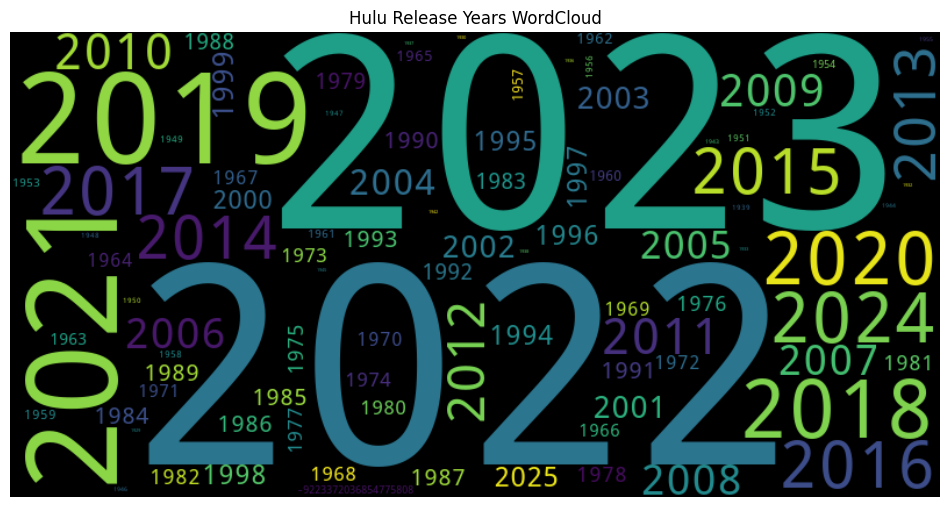

In [ ]:
# Create variable with value counts of each release year
release_yr_cnts = hulu_tv["Release_Year"].value_counts()

# Convert the index of the Release Years from integers to strings because WordCloud requires strings inputs
release_yr_cnts.index = release_yr_cnts.index.map(str)

# Create the WordCloud specifying 
hulu_tv_wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate_from_frequencies(release_yr_cnts)

# Setting figure size in inches
plt.figure(figsize = (12, 8))
# Show the created WordCloud with a bilinear interpolation, which is used to estimate the value of pixels used to generate the image
plt.imshow(hulu_tv_wordcloud, interpolation = "bilinear")
# Do not display axes
plt.axis("off")
# Create a title for the WordCloud
plt.title("Hulu Release Years WordCloud")
# Display plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

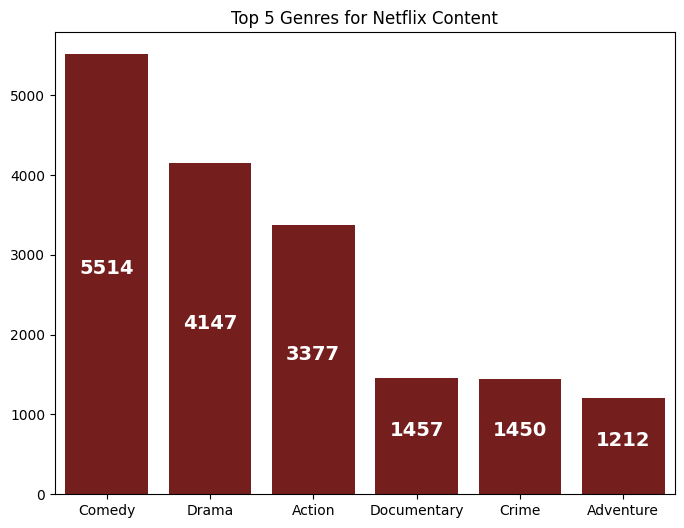

In [ ]:
# Separate the Hulu rows from the rest of the df
netflix_tv = streaming_clean[streaming_clean["Service_Name"] == "Netflix"] 
# Group the Genre_1 column and get the total counts for each genre
netflix_tv_genres = netflix_tv.groupby("Genre_1")["Genre_1"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_netflix_tv_genres = netflix_tv_genres.sort_values("Count", ascending = False).head(6)

plt.figure(figsize = (8, 6))
# Create a bar plot with specific color
sn.barplot(x = top_netflix_tv_genres["Genre_1"], y = top_netflix_tv_genres["Count"], color = "#831010")
# Plot the value counts of each genre inside the bar centered vertically in white font
# i = the index of each element in the series as an integer that starts at 0 and increments by 1 for each iteration 
# v = the value of each element in the series as the actual count & is a numeric value
# str(v) = converts the value of v to a string to be used in the bar plot
for i, v in enumerate(top_netflix_tv_genres["Count"]):
    plt.text(i, v/2, str(v), color = "white", ha = "center", fontsize = 14, fontweight = 600)
# Remove x and y labels
plt.xlabel(None)
plt.ylabel(None)
# Set title
plt.title("Top 5 Genres for Netflix Content")
# Display plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

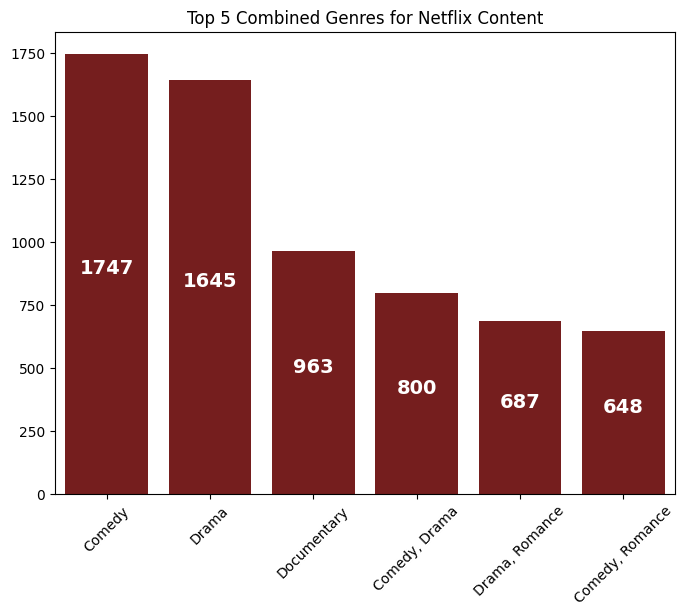

In [ ]:
# Group the Genre_1 column and get the total counts for each genre
netflix_tv_genres = netflix_tv.groupby("Combined_Genres")["Combined_Genres"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_netflix_tv_genres = netflix_tv_genres.sort_values("Count", ascending = False).head(6)
# Set figure size 
plt.figure(figsize = (8, 6))
# Create a bar plot with specific color
sn.barplot(x = top_netflix_tv_genres["Combined_Genres"], y = top_netflix_tv_genres["Count"], color = "#831010")
# Plot the value counts of each genre inside the bar centered vertically in white font
# i = the index of each element in the series as an integer that starts at 0 and increments by 1 for each iteration 
# v = the value of each element in the series as the actual count & is a numeric value
# str(v) = converts the value of v to a string to be used in the bar plot
for i, v in enumerate(top_netflix_tv_genres["Count"]):
    plt.text(i, v/2, str(v), color = "white", ha = "center", fontsize = 14, fontweight = 600)
# Remove x and y labels
plt.xlabel(None)
plt.ylabel(None)
# Reset x tick labels for readability
plt.xticks(rotation = 45)
# Set title
plt.title("Top 5 Combined Genres for Netflix Content")
# Display plot
plt.show

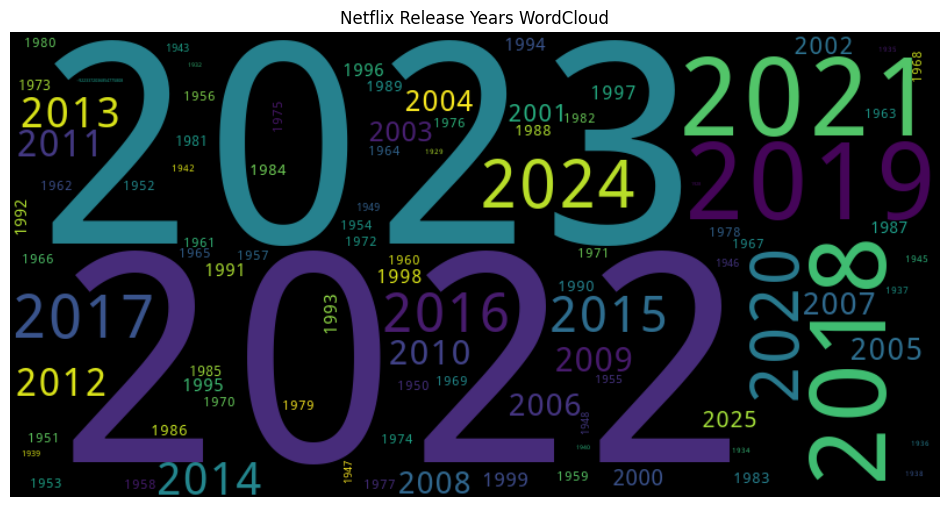

In [263]:
# Create variable with value counts of each release year
release_yr_cnts = netflix_tv["Release_Year"].value_counts()

# Convert the index of the Release Years from integers to strings because WordCloud requires strings inputs
release_yr_cnts.index = release_yr_cnts.index.map(str)

# Create the WordCloud specifying 
netflix_tv_wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate_from_frequencies(release_yr_cnts)

# Setting figure size in inches
plt.figure(figsize = (12, 8))
# Show the created WordCloud with a bilinear interpolation, which is used to estimate the value of pixels used to generate the image
plt.imshow(netflix_tv_wordcloud, interpolation = "bilinear")
# Do not display axes
plt.axis("off")
# Create a title for the WordCloud
plt.title("Netflix Release Years WordCloud")
# Show the plot
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

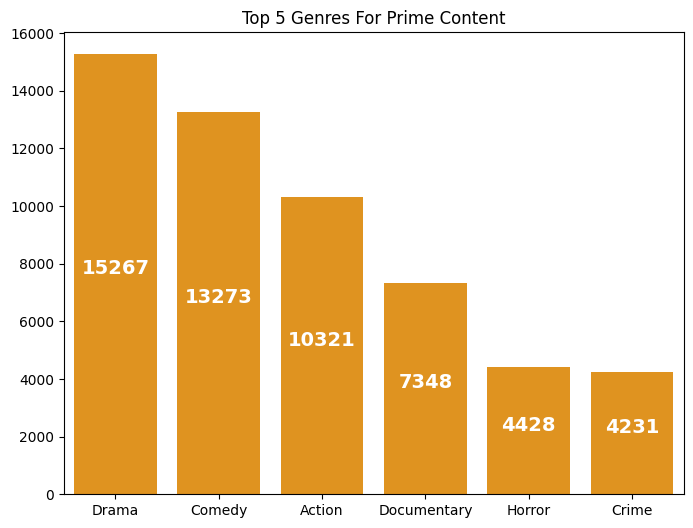

In [316]:
# Separate the Hulu rows from the rest of the df
prime_tv = streaming_clean[streaming_clean["Service_Name"] == "Prime"] 
# Group the Genre_1 column and get the total counts for each genre
prime_tv_genres = prime_tv.groupby("Genre_1")["Genre_1"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_prime_tv_genres = prime_tv_genres.sort_values("Count", ascending = False).head(6)
# Set figure size 
plt.figure(figsize = (8, 6))
# Create a bar plot with specific color
sn.barplot(x = top_prime_tv_genres["Genre_1"], y = top_prime_tv_genres["Count"], color = "#FF9900")
# Plot the value counts of each genre inside the bar centered vertically in white font
# i = the index of each element in the series as an integer that starts at 0 and increments by 1 for each iteration 
# v = the value of each element in the series as the actual count & is a numeric value
# str(v) = converts the value of v to a string to be used in the bar plot
for i, v in enumerate(top_prime_tv_genres["Count"]):
    plt.text(i, v/2, str(v), color = "white", ha = "center", fontsize = 14, fontweight = 600)
# Remove x and y labels
plt.xlabel(None)
plt.ylabel(None)
# Set title
plt.title("Top 5 Genres For Prime Content")
# Display plot
plt.show

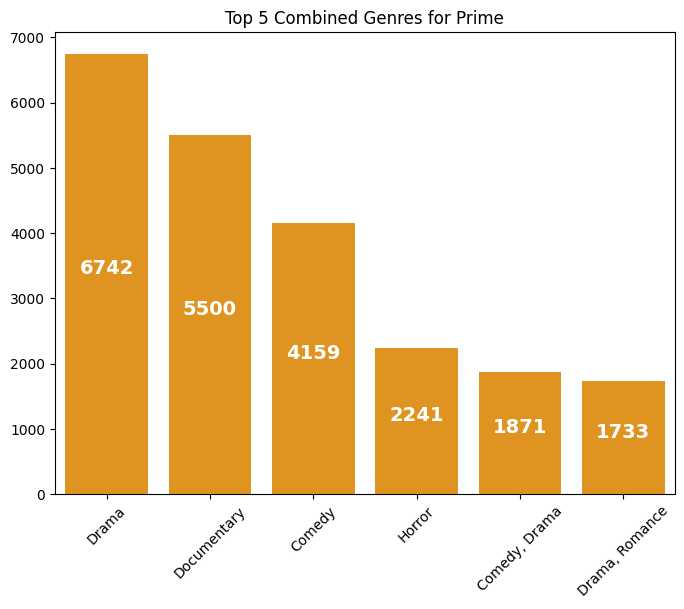

In [317]:
# Group the Genre_1 column and get the total counts for each genre
prime_tv_genres = prime_tv.groupby("Combined_Genres")["Combined_Genres"].count().reset_index(name = "Count")
# Ascertain the top 5 genres
top_prime_tv_genres = prime_tv_genres.sort_values("Count", ascending = False).head(6)
# Set figure size 
plt.figure(figsize = (8, 6))
# Create a bar plot with specific color
sn.barplot(x = top_prime_tv_genres["Combined_Genres"], y = top_prime_tv_genres["Count"], color = "#FF9900")
# Plot the value counts of each genre inside the bar centered vertically in white font
# i = the index of each element in the series as an integer that starts at 0 and increments by 1 for each iteration 
# v = the value of each element in the series as the actual count & is a numeric value
# str(v) = converts the value of v to a string to be used in the bar plot
for i, v in enumerate(top_prime_tv_genres["Count"]):
    plt.text(i, v/2, str(v), color = "white", ha = "center", fontsize = 14, fontweight = 600)
# Remove x and y labels
plt.xlabel(None)
plt.ylabel(None)
# Reset x tick labels for readability
plt.xticks(rotation = 45)
# Set title
plt.title("Top 5 Combined Genres for Prime")
# Display plot
plt.show()

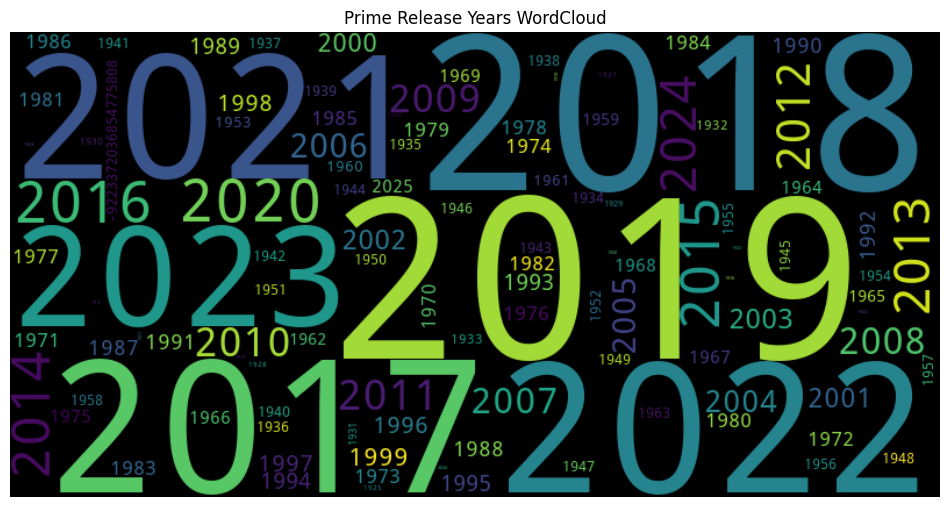

In [266]:
# Create variable with value counts of each release year
release_yr_cnts = prime_tv["Release_Year"].value_counts()

# Convert the index of the Release Years from integers to strings because WordCloud requires strings inputs
release_yr_cnts.index = release_yr_cnts.index.map(str)

# Create the WordCloud specifying 
prime_tv_wordcloud = WordCloud(width = 800, height = 400, background_color = "black").generate_from_frequencies(release_yr_cnts)

# Setting figure size in inches
plt.figure(figsize = (12, 8))
# Show the created WordCloud with a bilinear interpolation, which is used to estimate the value of pixels used to generate the image
plt.imshow(prime_tv_wordcloud, interpolation = "bilinear")
# Do not display axes
plt.axis("off")
# Create a title for the WordCloud
plt.title("Prime Release Years WordCloud")
# Show the plot
plt.show()

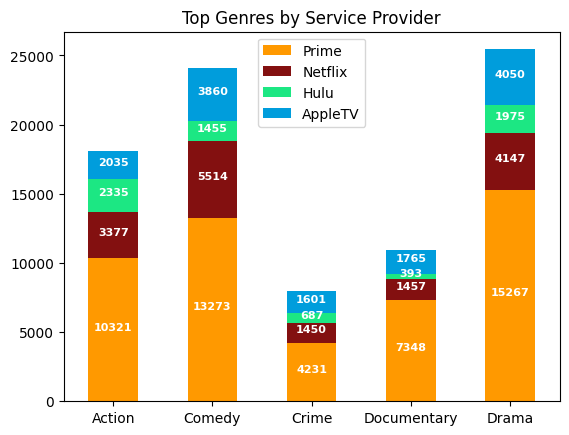

In [321]:
# Graph the top 5 individual genres in Genre_1 by Service_Name to compare which services offer the most 
# Limit Genre_1 to the top 5 counts
top_5 = streaming_clean["Genre_1"].value_counts().head(5).index

# Filter the original DataFrame to include only the top 5 values
genre1_top5 = streaming_clean[streaming_clean["Genre_1"].isin(top_5)]

# Group by Genre_1 and count the number of each genre by Service Name
genre_counts = genre1_top5.groupby("Genre_1")["Service_Name"].value_counts().unstack()

# Sort the values in the DataFrame before plotting
genre_counts = genre_counts.sort_index(axis=1, ascending=False)

# Plot the result of the grouped data above as a stacked bar plot with specific coloring
genre_counts.plot(kind =  "bar", stacked = True, color = ["#FF9900","#831010","#1CE783","#009DDC"])
# Relable the x axis
plt.xlabel(None)
# Reposition the x labels so they are horizontal with the x axis
plt.xticks(rotation = 360)
# Move legend to the top and center
plt.legend(loc = "upper center")
# Set title
plt.title("Top Genres by Service Provider")
# Display values in the center of each stacked bar
for i, col in enumerate(genre_counts.columns):
    for j, v in enumerate(genre_counts[col]):
        if v > 0:
            # Calculate the y position of the text to be plotted
            y_pos = sum(genre_counts.iloc[j, :i].values)
            # Plot the text
            plt.text(j, y_pos + v/2, str(v), color="white", ha="center", fontsize=8, fontweight='bold')
# Display plot
plt.show()

In [ ]:
# Now I want to view specific TV show content based on titles I enjoy watching 
my_shows = streaming_clean[streaming_clean["Title"].isin(["Tracker", "Elsbeth", "Matlock", "Watson", "Suits"])].sort_values("Title")
my_shows

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7
17595,Elsbeth,tv,"Comedy, Crime, Drama",2024,tt26591110,7.6,12638,AppleTV,Comedy,Crime,Drama,None,None,None,None
14412,Matlock,tv,"Crime, Drama, Mystery",1986,tt0090481,7.1,10062,AppleTV,Crime,Drama,Mystery,None,None,None,None
17592,Matlock,tv,"Crime, Drama",2024,tt26591147,7.6,9235,AppleTV,Crime,Drama,None,None,None,None,None
24775,Suits,tv,"Comedy, Drama",2011,tt1632701,8.4,510598,Hulu,Comedy,Drama,None,None,None,None,None
44088,Suits,tv,"Comedy, Drama",2011,tt1632701,8.4,510598,Netflix,Comedy,Drama,None,None,None,None,None
111945,Suits,tv,"Comedy, Drama",2011,tt1632701,8.4,510598,Prime,Comedy,Drama,None,None,None,None,None
15356,Tracker,tv,"Crime, Drama",2024,tt13875494,7.1,19499,AppleTV,Crime,Drama,None,None,None,None,None
25196,Tracker,tv,"Crime, Drama",2024,tt13875494,7.1,19499,Hulu,Crime,Drama,None,None,None,None,None
59721,Tracker,movie,"Action, Adventure, Drama",2010,tt1414378,6.5,4296,Prime,Action,Adventure,Drama,None,None,None,None
110516,Tracker,tv,"Action, Drama, Romance",2001,tt0292858,6.0,474,Prime,Action,Drama,Romance,None,None,None,None


In [ ]:
# Remove rows with "movie" in Content_Type and specific Release_Years which I know are not related to the shows I watch
my_shows = my_shows[(my_shows["Content_Type"] != "movie") & (my_shows["Release_Year"] != 1986) & (my_shows["Release_Year"] != 2001)]
my_shows

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7
17595,Elsbeth,tv,"Comedy, Crime, Drama",2024,tt26591110,7.6,12638,AppleTV,Comedy,Crime,Drama,None,None,None,None
17592,Matlock,tv,"Crime, Drama",2024,tt26591147,7.6,9235,AppleTV,Crime,Drama,None,None,None,None,None
24775,Suits,tv,"Comedy, Drama",2011,tt1632701,8.4,510598,Hulu,Comedy,Drama,None,None,None,None,None
44088,Suits,tv,"Comedy, Drama",2011,tt1632701,8.4,510598,Netflix,Comedy,Drama,None,None,None,None,None
111945,Suits,tv,"Comedy, Drama",2011,tt1632701,8.4,510598,Prime,Comedy,Drama,None,None,None,None,None
15356,Tracker,tv,"Crime, Drama",2024,tt13875494,7.1,19499,AppleTV,Crime,Drama,None,None,None,None,None
25196,Tracker,tv,"Crime, Drama",2024,tt13875494,7.1,19499,Hulu,Crime,Drama,None,None,None,None,None
17780,Watson,tv,"Drama, Mystery",2024,tt22475008,5.0,2703,AppleTV,Drama,Mystery,None,None,None,None,None


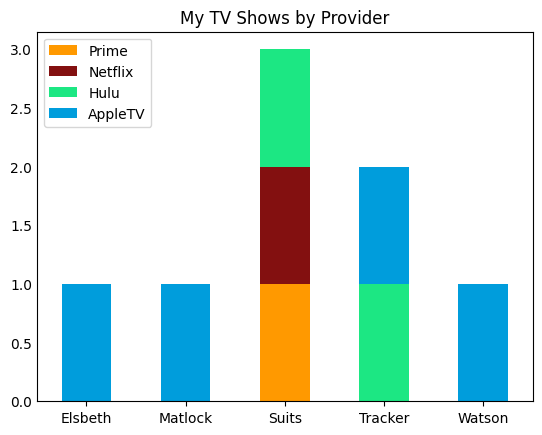

In [270]:
# Group by Title and count the number of each title by Service Name
my_shows = my_shows.groupby("Title")["Service_Name"].value_counts().unstack()

# Sort the values in the DataFrame before plotting
my_shows = my_shows.sort_index(axis=1, ascending=False)

# Plot the result of the grouped data above as a stacked bar plot with specific coloring for each service provider
my_shows.plot(kind =  "bar", stacked = True, color = ["#FF9900","#831010","#1CE783","#009DDC"])
# Remove y-axis ticks
plt.tick_params(axis='y', which='both', length=0)  

plt.ylabel(None)
# Relable the x axis
plt.xlabel(None)
# Reposition the x labels so they are horizontal with the x axis
plt.xticks(rotation = 360)
# Move legend to the top and center
plt.legend(loc = "upper left")
# Create a graph title
plt.title("My TV Shows by Provider")
# Show the graph
plt.show()

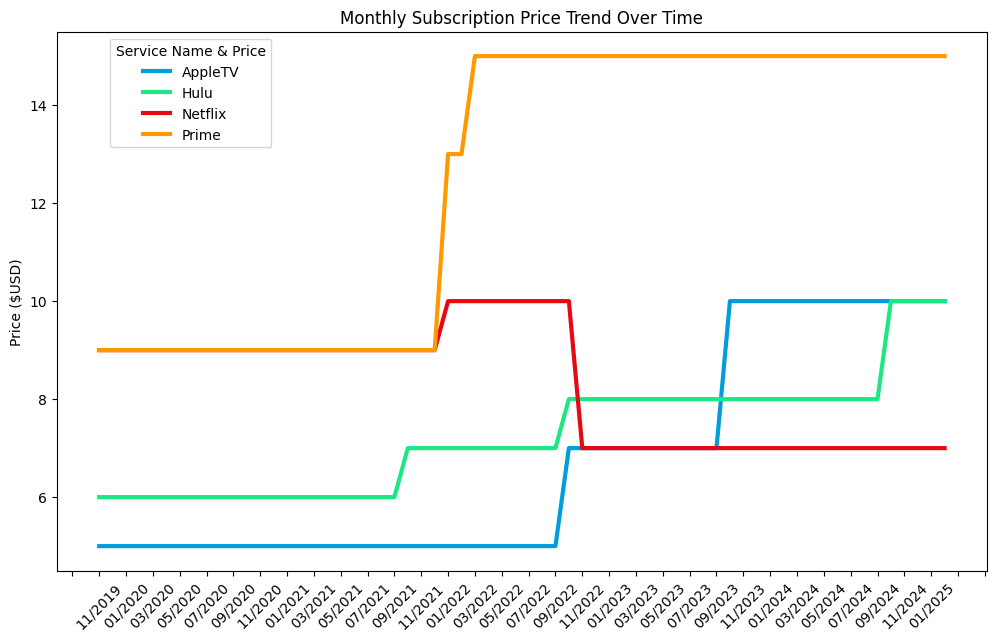

In [ ]:
plt.figure(figsize = (12, 7))
# Group the data by Service_Name and plot the prices over time
# Define a dictionary to map service names to colors
colors = {
    "AppleTV" : "#009DDC",
    "Hulu" : "#1CE783",
    "Netflix" : "#E50914",
    "Prime" : "#FF9900"
}
# Start a loop that iterates over each unique value in the Service_Name column and return as numpy array
for service in prices["Service_Name"].unique():
    # Create a new df that contains only the row where Service_Name matches the current value in the loop & select the desired row
    platforms = prices[prices["Service_Name"] == service]
    # Create a line plot with the new df using Date for x axis and price for y axis & specify the label for the plot line by the service name iterated perviously
    plt.plot(platforms["Date"], platforms["Price"], label = service, color=colors[service], linewidth=3)
# Set the chart title and labels
plt.title("Monthly Subscription Price Trend Over Time")
plt.ylabel("Price ($USD)")
# Rotate the x axis lables for better readability 
plt.xticks(rotation = 45)
# Skip every other x tick for better readability
plt.gca().xaxis.set_major_locator(MultipleLocator(2))
# Plot the legend so you know which line corresponds to which Service Name
# plt.legend(loc="best", bbox_to_anchor=(1, 1), title="Service Name and Price")
plt.legend(loc="upper left", bbox_to_anchor=(0.05, 1), title="Service Name & Price")
# Display the plot
plt.show()